## 猫狗二分类

**1. 组织数据**

将所下载的压缩包 `train.zip` 在目录 `./data` 中解压缩。并在 `./data/train` 中创建两个子目录，即 `./data/train/cats` 和 `./data/train/dogs` 。然后创建子目录 `./data/val` ，在其中也创建另两个子目录 `./data/val/dogs` 和 `./data/val/cats` 。将 `./data/train` 中的数据称为**训练集**，`./data/val` 中的称为**验证集**。

将所下载的压缩包 `test.zip` 也在 `./data` 中解压缩，得到子目录 `./data/test` ，此目录中的数据称为**测试集**。

经过上述操作之后，得到了如下所示的目录结构：

```python
% tree data -d
data
├── test
├── train
│   ├── cats
│   └── dogs
└── val
    ├── cats
    └── dogs

7 directories
```

然后写一段代码，按照前述要求，将本来已经存在 `./data/train` 中的图片，按照文件名中所标示出的 `dog` 和 `cat` 分别移动到 `./data/train/cats` 和 `./data/train/dogs` 目录中。

In [26]:
import re
import shutil
import os

# 训练集目录
train_dir = "./data/train"
train_dogs_dir = f"{train_dir}/dogs"
train_cats_dir = f"{train_dir}/cats"
# 验证集目录
val_dir = "./data/val"
val_dogs_dir = f"{val_dir}/dogs"
val_cats_dir = f"{val_dir}/cats"

files = os.listdir(train_dir) 
for f in files:
    cat_search = re.search('cat', f)  # 用正在表达式判断字符串 cat 是否在其中
    dog_search = re.search('dog', f)
    if cat_search:
        shutil.move(f'{train_dir}/{f}', train_cats_dir)  # 能够将文件移动到指定目录中
    if dog_search:
        shutil.move(f"{train_dir}/{f}", train_dogs_dir)

运行代码块后，将猫和狗的图片分别放在了两个不同的目录中

In [27]:
print("目录 train_dir 中已经没有图片")
!ls {train_dir} | head -n 5

print("目录 train_dogs_dir 中是狗图片（显示5个）")
!ls {train_dogs_dir} | head -n 5

print("目录 train_cats_dir 中是猫图片（显示5个）")
!ls {train_cats_dir} | head -n 5

目录 train_dir 中已经没有图片
cats
dogs
目录 train_dogs_dir 中是狗图片（显示5个）
dog.0.jpg
dog.1.jpg
dog.10.jpg
dog.100.jpg
dog.1000.jpg
目录 train_cats_dir 中是猫图片（显示5个）
cat.0.jpg
cat.1.jpg
cat.10.jpg
cat.100.jpg
cat.1000.jpg


在 `./data/train/cats` 和 `./data/train/dogs` 两个目录中，各有 12500 张图片，再从每个目录中取一部分（此处取 1000 张）图片分别放到对应的验证集目录 `./data/val/cats` 和 `./data/val/dogs` 中。

In [30]:
# 将文件名中 `<id>` 为 7000 至 7999 的图片移动到相应的验证集目录中
dogs_files = os.listdir(train_dogs_dir)
cats_files = os.listdir(train_cats_dir)

for dog in dogs_files:
    val_dog_search = re.search("7\d\d\d", dog)
    if val_dog_search:
        shutil.move(f"{train_dogs_dir}/{dog}", val_dogs_dir)

for cat in cats_files:
    val_cat_search = re.search("7\d\d\d", cat)
    if val_cat_search:
        shutil.move(f"{train_cats_dir}/{cat}", val_cats_dir)
        
print("目录 val_dogs_dir 中是狗图片")
!ls {val_dogs_dir} | head -n 5
print("目录 val_cats_dir 中是狗图片")
!ls {val_cats_dir} | head -n 5

目录 val_dogs_dir 中是狗图片
dog.7000.jpg
dog.7001.jpg
dog.7002.jpg
dog.7003.jpg
dog.7004.jpg
目录 val_cats_dir 中是狗图片
cat.7000.jpg
cat.7001.jpg
cat.7002.jpg
cat.7003.jpg
cat.7004.jpg


**2. 训练模型**

数据已经组织好了，即将使用 PyTorch 创建并训练模型。PyTorch 的官方网站是：https://pytorch.org/ ，它提供了非常友好的 Python 接口，与其他第三方包一样，安装后即可使用。

```shell
% pip install torch torchvision
```

In [31]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import time
import os
import copy
import math

torch.__version__

'1.6.0'

- 数据扩充（或称“数据增强”、“数据增广”，data augmentataion）往往是不可避免的，最简单的数据扩充方法包括翻转、旋转、尺度变换等等。

- 另外，由于不同的图片大小各异，也需要将图片尺寸规范到限定的范围。

- 要张量化，才能用于模型的张量运算（关于“张量”的基本概念，参阅拙作《机器学习数学基础》）。

In [32]:
# 用 `data_transforms` 定义训练集和验证集数据，以及必要的常量。

data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(5),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)), 
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize([224, 224]), 
                               transforms.ToTensor(), 
                               transforms.Normalize([0.485, 0.456, 0.406], 
                                                    [0.229, 0.224, 0.225])]),
}

In [33]:
data_dir = 'data'
CHECK_POINT_PATH = './data/checkpoint.tar'   # 预训练模型，
SUBMISSION_FILE = "./data/submission.csv"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(class_names)
print(f"Train image size: {dataset_sizes['train']}")
print(f"Validation image size: {dataset_sizes['val']}")

['cats', 'dogs']
Train image size: 23000
Validation image size: 2000


训练集中的图片数量是 23000，验证集有 2000 张图片。

在上述代码块的 `dataloaders` 中设置 `batch_size=4` （batch，常译为“批”），训练集中由 4 张图片组成的“1批”（随机抽取）。

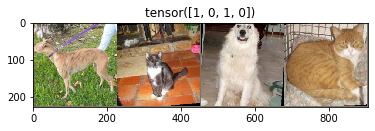

In [34]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 获取训练集中的批（batch）
inputs, classes = next(iter(dataloaders['train']))

sample_train_images = torchvision.utils.make_grid(inputs)

imshow(sample_train_images, title=classes)

# 这批（batch）图片即对应于张量 `tensor([1, 0, 1, 0])` 。

In [35]:
# 训练模型的函数

def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint = None):
    since = time.time()

    if checkpoint is None:  # 为 True 则加载训练的模型，并更新参数，否则从头开始训练，本例中使用预训练模型
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.deepcopy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每轮（epoch）含一次训练和验证
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 梯度归零
                optimizer.zero_grad()
                
                if i % 200 == 199:
                    print(f'[{epoch+1}, {i}] loss: {running_loss/(i*inputs.size(0)):.3f}')

                # 前向
                # 跟踪训练过程
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 后向/反向，在训练过程中
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 深拷贝模型
            if phase == 'val' and epoch_loss < best_loss:
                print(f'New best model found!')
                print(f'New record loss: {epoch_loss}, previous record loss: {best_loss}')
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f} Best val loss: {best_loss:.4f}')

    # 载入最佳的模型权重
    model.load_state_dict(best_model_wts)
    return model, best_loss, best_acc

In [50]:
# 载入卷积神经网络模型

# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context
model_conv = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /Users/qiwsir/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [51]:
for param in model_conv.parameters():
    param.requires_grad = False    # 仅训练导入的卷积神经网络 resnet50 模型的最后一层参数

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()    # 损失函数：交叉熵

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)  # 优化器算法：随机梯度下降

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)  # 学习率

In [54]:
# 训练过程，可能时间较长

CHECK_POINT_PATH = './data/checkpoint.tar'
SUBMISSION_FILE = "./data/submission.csv"
try:
    checkpoint = torch.load(CHECK_POINT_PATH)
    print("checkpoint loaded")
except:
    checkpoint = None
    print("checkpoint not found")

# model_conv, best_val_loss, best_val_acc = train_model(model_conv,
#                                                       criterion,
#                                                       optimizer_conv,
#                                                       exp_lr_scheduler,
#                                                       num_epochs = 3,
#                                                       checkpoint = checkpoint)
# torch.save({'model_state_dict': model_conv.state_dict(),
#             'optimizer_state_dict': optimizer_conv.state_dict(),
#             'best_val_loss': best_val_loss,
#             'best_val_accuracy': best_val_acc,
#             'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
#             }, CHECK_POINT_PATH)

checkpoint loaded


In [55]:
model_conv, best_val_loss, best_val_acc = train_model(model_conv,
                                                      criterion,
                                                      optimizer_conv,
                                                      exp_lr_scheduler,
                                                      num_epochs = 3,
                                                      checkpoint = checkpoint)
torch.save({'model_state_dict': model_conv.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_accuracy': best_val_acc,
            'scheduler_state_dict' : exp_lr_scheduler.state_dict(),
            }, CHECK_POINT_PATH)

Val loss: 0.03336585155675109, Val accuracy: 1.0
Epoch 0/2
----------
[1, 199] loss: 0.240
[1, 399] loss: 0.216
[1, 599] loss: 0.214
[1, 799] loss: 0.219
[1, 999] loss: 0.226
[1, 1199] loss: 0.226
[1, 1399] loss: 0.222
[1, 1599] loss: 0.223
[1, 1799] loss: 0.230
[1, 1999] loss: 0.231
[1, 2199] loss: 0.231
[1, 2399] loss: 0.230
[1, 2599] loss: 0.233
[1, 2799] loss: 0.234
[1, 2999] loss: 0.234
[1, 3199] loss: 0.234
[1, 3399] loss: 0.235
[1, 3599] loss: 0.236
[1, 3799] loss: 0.235
[1, 3999] loss: 0.236
[1, 4199] loss: 0.237
[1, 4399] loss: 0.234
[1, 4599] loss: 0.235
[1, 4799] loss: 0.234
[1, 4999] loss: 0.233
[1, 5199] loss: 0.233
[1, 5399] loss: 0.232
[1, 5599] loss: 0.234
train Loss: 0.2325 Acc: 0.9055
[1, 199] loss: 0.068
[1, 399] loss: 0.068
val Loss: 0.0699 Acc: 0.9770

Epoch 1/2
----------
[2, 199] loss: 0.196
[2, 399] loss: 0.202
[2, 599] loss: 0.227
[2, 799] loss: 0.239
[2, 999] loss: 0.236
[2, 1199] loss: 0.240
[2, 1399] loss: 0.245
[2, 1599] loss: 0.243
[2, 1799] loss: 0.238
[2

当上述代码块运行完毕，就训练好了一个具有识别猫、狗能力的模型 `model_conv` 。

然后编写如下代码，检验模型在验证集上的“识别”结果。

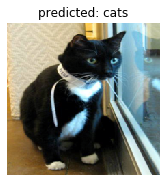

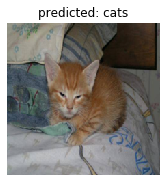

In [57]:
def visualize_model(model, num_images=2):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
visualize_model(model_conv)

**3. 测试模型**

保存在子目录 `./data/test` 里面的图片为“测试集” ，现在就用它们来检验模型的“识别”能力。测试集中的每个图片文件以 `<id>.jpg` 格式命名，从文件名上不知道它是猫还是狗。

本来，可以用 PyTorch 直接从 `.data/test` 中读入数据。但是，为了展示一些 Python 库的应用，此处改用另外的方式。首先，创建一个将图片转换为张量的函数。

In [58]:
def apply_test_transforms(inp):
    out = transforms.functional.resize(inp, [224,224])
    out = transforms.functional.to_tensor(out)
    out = transforms.functional.normalize(out, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    return out

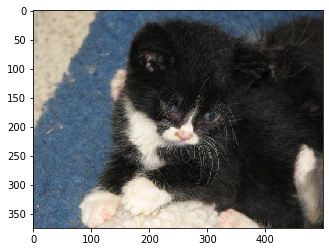

In [59]:
from PIL import Image

test_data_dir = f'{data_dir}/test'
test_data_files = os.listdir(test_data_dir)
im = Image.open(f'{test_data_dir}/{test_data_files[0]}')
plt.imshow(im)

In [60]:
# 测试 im
im_as_tensor = apply_test_transforms(im)
print(im_as_tensor.size())
minibatch = torch.stack([im_as_tensor])
print(minibatch.size())

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


In [61]:
preds = model_conv(minibatch)
preds

tensor([[ 2.0083, -1.8386]], grad_fn=<AddmmBackward>)

In [62]:
soft_max = nn.Softmax(dim=1)
probs = soft_max(preds)
probs  

tensor([[0.9791, 0.0209]], grad_fn=<SoftmaxBackward>)

将张量里面的数字转化为百分比，`probs` 的结果说明模型 `model_conv` “认为”这张图片是猫的概率为 97.91% 。

**4. 参加 kaggle 比赛**

本项目来自于 kaggle.com ，这是一个著名的深度学习竞赛网站，如果打算参加，必须要按照网站要求提交 `submission.csv` 的文件（“Dogs vs. Cats”的竞赛项目已经结束，可以参考下述方法，以备参加其他项目），基本格式为：

```tex
id,label
1,0.5
2,0.5
```

其中 `id` 是测试集（`./data/test` ）中所有图片的 `<id>` ，`label` 为该图片是狗的概率。

In [63]:
def predict_dog(model, tensor):
    batch = torch.stack([tensor])
    softMax = nn.Softmax(dim = 1)
    preds = softMax(model(batch))
    return preds[0, 1].item()
          
def test_data(fname):
    im = Image.open(f'{test_data_dir}/{fname}')
    return apply_test_transforms(im)
        
import re
def extract_file_id(fname):      # 从文件名中提取 id
    print("Extracting id from " + fname)
    return int(re.search('\d+', fname).group())

In [64]:
model_conv.eval()
id_to_dog_prob = {extract_file_id(fname): predict_dog(model_conv,test_data(fname)) for fname in test_data_files}

Extracting id from 9733.jpg
Extracting id from 63.jpg
Extracting id from 6400.jpg
Extracting id from 823.jpg
Extracting id from 4217.jpg
Extracting id from 3578.jpg
Extracting id from 10321.jpg
Extracting id from 2666.jpg
Extracting id from 5109.jpg
Extracting id from 11981.jpg
Extracting id from 10447.jpg
Extracting id from 2100.jpg
Extracting id from 11759.jpg
Extracting id from 4571.jpg
Extracting id from 7078.jpg
Extracting id from 12250.jpg
Extracting id from 1409.jpg
Extracting id from 9055.jpg
Extracting id from 6366.jpg
Extracting id from 12244.jpg
Extracting id from 189.jpg
Extracting id from 9041.jpg
Extracting id from 6372.jpg
Extracting id from 11995.jpg
Extracting id from 10453.jpg
Extracting id from 2114.jpg
Extracting id from 4565.jpg
Extracting id from 4203.jpg
Extracting id from 10335.jpg
Extracting id from 2672.jpg
Extracting id from 9727.jpg
Extracting id from 6414.jpg
Extracting id from 77.jpg
Extracting id from 8439.jpg
Extracting id from 837.jpg
Extracting id from

In [65]:
import pandas as pd

ds = pd.Series({id : label for (id, label) in zip(id_to_dog_prob.keys(), id_to_dog_prob.values())})
df = pd.DataFrame(ds, columns = ['label']).sort_index()
df['id'] = df.index
df = df[['id', 'label']]
df.to_csv(SUBMISSION_FILE, index = False)

In [70]:
df.sample(5)

,id,label
5548,5548,0.999494
8238,8238,0.998453
8961,8961,0.999983
4762,4762,0.003668
2623,2623,0.000197
